# Lap Efficiency Correlation Analysis

This notebook will compare multiple variables with lap efficiency to find possible covariates that will help us optimze for lap efficiency.

### Imports

In [ ]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
from data_tools.collections.fsgp_2024_laps import FSGPDayLaps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import datetime


FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


### Getting Lap Efficiencies

We reuse functions previously made by [Jonah Lee](https://github.com/UBC-Solar/data_analysis/pull/2). Check his PR, linked on his name, for more information on the below functions, or refer to his original notebook [fsgp_2024_lap_efficiency.ipynb](./fsgp_2024_lap_efficiency.ipynb).


In [7]:
def calculate_lap_power(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    
    print(f"{start_time=}\n{end_time=}")
    
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_voltage, motor_current_dir = TimeSeries.align(raw_motor_current, motor_voltage, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

In [8]:
def calculate_lap_energy(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = calculate_lap_power(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

In [ ]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())  # We are missing data after this point!
num_laps = len(day_1_idx) + len(day_3_idx)

lap_energies = []
lap_drivers = []
lap_speeds = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        
        lap_energies.append(calculate_lap_energy(lap_start, lap_end, data_client))
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))

lap_energies = np.array([arr[-1] for arr in lap_energies])
lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 40, 21, tzinfo=datetime.timezone.utc)
start_time=date

## Lap Efficiency and Average Speed (mph)

Below are plots of `lap efficiency` and `average speed` in miles per hour

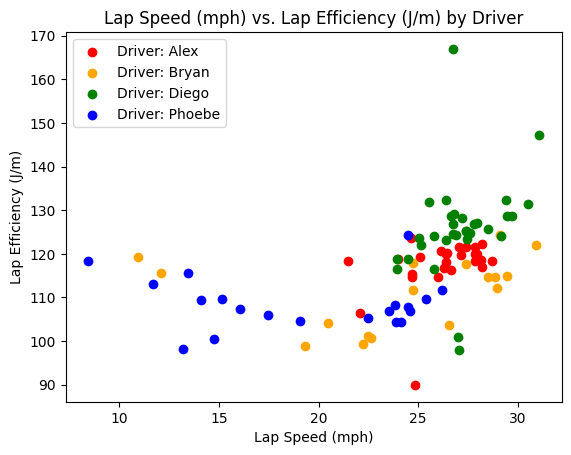

In [ ]:
# Also from Jonah 
lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

for driver, colour in driver_colours.items():
    plt.scatter(lap_speeds[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Driver")
plt.show()

A quadratic relationship can be seen between `lap efficiency` and `average speed`, let's trying fitting a function to the data

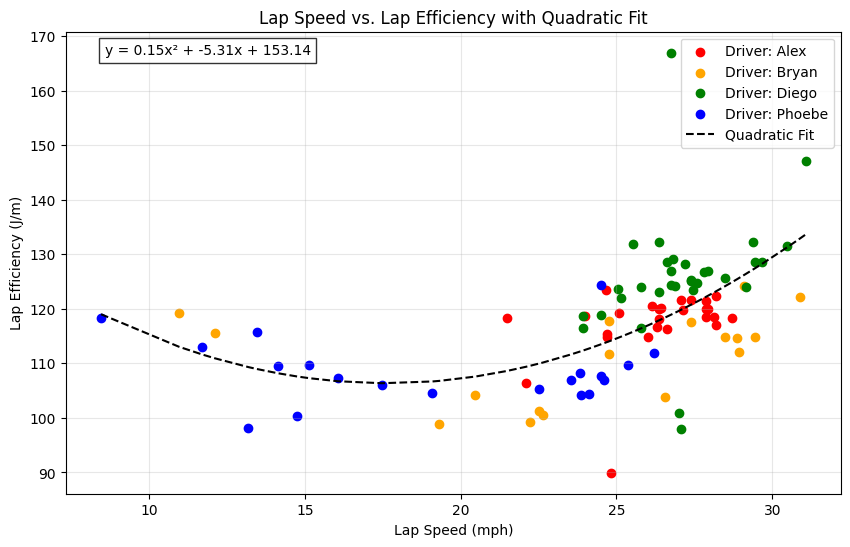

In [ ]:
# Combine all data for the overall fit
all_speeds = np.array(lap_speeds)
all_efficiencies = np.array(lap_efficiencies)

# Sort data for plotting the fit line
sort_idx = np.argsort(all_speeds)
speeds_sorted = all_speeds[sort_idx]

# Define quadratic function for fitting
def quad_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function
popt, _ = curve_fit(quad_func, all_speeds, all_efficiencies)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual driver points
for driver, colour in driver_colours.items():
    mask = lap_drivers == driver
    plt.scatter(lap_speeds[mask], lap_efficiencies[mask],
                c=colour, label=f"Driver: {driver}")

# Plot the fitted curve
fit_y = quad_func(speeds_sorted, *popt)
plt.plot(speeds_sorted, fit_y, 'k--', label='Quadratic Fit')

# Add labels and title
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.title("Lap Speed vs. Lap Efficiency with Quadratic Fit")
plt.legend()

# Add the equation to the plot
equation = f'y = {popt[0]:.2f}x² + {popt[1]:.2f}x + {popt[2]:.2f}'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.show()